## Neural network to predict HT-PAMDA profile from amino acid sequence

## Set the parameters here...

In [1]:
run_name = "example_run"
model_name = "AA_to_PAM_NN" # Don't change
OVERWRITE_SAVED_MODEL = False # whether to write over previous runs with the same name


# !!!!!!
random_seed = 0

# Optimization parameters:

EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
DECAY = 0.001
DROPOUT_FRACTION = 0.2
test_fraction = 0.2


# Model parameters:
n_dense = [512, 256, 128] # depth and number of HIDDEN nodes in the network
ACTIVATION = 'relu'
LOSS = 'mse'

# data parameters
three_nt_PAM = True # Unless this is true will assume you are using 4nt PAM
LOW_RATE_CONSTANT_CUTOFF = -5
LOW_RATE_REPLACE = -5
HEATMAP_MAX = -1.5
HEATMAP_MIN = -5
plt_test_data = False
randomly_over_sample_by_most_active_PAM = True
encoding = 'onehot' # either 'georgiev' or 'onehot'



train_and_test_samples_csv = "./training_data/220924_6pos_selected_random_only.csv"



nts = ["A", "C", "G", "T"]
muts = ['D1135', 'S1136', 'G1218','E1219', 'R1335', 'T1337']
pams_2_3_4 = ['AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG',
       'ACT', 'AGA', 'AGC', 'AGG', 'AGT', 'ATA', 'ATC', 'ATG', 'ATT', 'CAA',
       'CAC', 'CAG', 'CAT', 'CCA', 'CCC', 'CCG', 'CCT', 'CGA', 'CGC', 'CGG',
       'CGT', 'CTA', 'CTC', 'CTG', 'CTT', 'GAA', 'GAC', 'GAG', 'GAT', 'GCA',
       'GCC', 'GCG', 'GCT', 'GGA', 'GGC', 'GGG', 'GGT', 'GTA', 'GTC', 'GTG',
       'GTT', 'TAA', 'TAC', 'TAG', 'TAT', 'TCA', 'TCC', 'TCG', 'TCT', 'TGA',
       'TGC', 'TGG', 'TGT', 'TTA', 'TTC', 'TTG', 'TTT']
pams = ["N" + x for x in pams_2_3_4]

In [2]:
from functions import *
import numpy as np
from scipy import stats
import pandas as pd
import random as rand
import tensorflow as tf
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
rand.seed(random_seed)



# Write the parameters to log
if not os.path.isdir("./PAMmla outputs"):
    os.mkdir("./PAMmla outputs")
if not os.path.isdir("./PAMmla outputs/" + model_name):
    os.mkdir("./PAMmla outputs/" + model_name)
run_directory_path = "./PAMmla outputs/" + model_name + "/" + run_name
if not os.path.isdir(run_directory_path):
    os.mkdir(run_directory_path)
all_vars = dir()
with open("".join([run_directory_path,'/variables_log.txt']), 'w') as f:
    for name in all_vars:
        if not name.startswith('_') and "<" not in str(eval(name)):
            line = "".join([name, " = ", str(eval(name)), " \n"])
            f.write(line)

# pickle the parameters
filename = "".join([run_directory_path, "/data_parameters.pkl"])
with open(filename, 'wb') as f:
    pickle.dump([run_name, model_name, three_nt_PAM, test_fraction, LOW_RATE_CONSTANT_CUTOFF, LOW_RATE_REPLACE, HEATMAP_MAX, HEATMAP_MIN, nts, muts, pams], f)


## Read and format the data

In [3]:
train_test_PAMDA_df = pd.read_csv(train_and_test_samples_csv)
print(train_test_PAMDA_df)

                  sample     prep status    name selected/rational  \
0    expRAS40_sample_014   RAS774   good  MWCAGG          selected   
1    expRAS40_sample_015   RAS775   good  LRRIMR          selected   
2    expRAS40_sample_016   RAS776   good  KWTMQT          selected   
3    expRAS40_sample_017   RAS777   good  GWSVCQ          selected   
4    expRAS40_sample_018   RAS778   good  AWNAQA          selected   
..                   ...      ...    ...     ...               ...   
765         expRW007_195  RTW3471   good  VMRCKL          selected   
766         expRW007_196  RTW3554   good  SRIAER          selected   
767         expRW007_197  RTW3568   good  LRLSAR          selected   
768         expRW060_002  RTW3835   good  LCRQQR          selected   
769         expRW060_003  RTW3832   good  CWSHQR          selected   

              variant source              source library PAM selected on  \
0                   expRAS37  MMW94 - 6 position library            NGTT   
1      

In [4]:
# make very low rate constants a very small number to get rid of noise (the very low ones are not meaningful)
train_test_PAMDA_df[pams] = np.where(train_test_PAMDA_df[pams] <= LOW_RATE_CONSTANT_CUTOFF, LOW_RATE_REPLACE, train_test_PAMDA_df[pams])

# make sure there are no duplicates
duplicate_values = train_test_PAMDA_df["name"].duplicated()
print("Any duplicates?:", any(duplicate_values))

Any duplicates?: False


In [5]:
# normalize the data
DATA_MEAN = np.mean(np.array(train_test_PAMDA_df[pams]).flatten())
DATA_STD = np.std(np.array(train_test_PAMDA_df[pams]).flatten())
print("MEAN: ", DATA_MEAN)
print("STD: ", DATA_STD)

filename = "".join([run_directory_path, "/mean_std.pkl"])
with open(filename, 'wb') as f:
    pickle.dump([DATA_MEAN, DATA_STD], f)

for col in pams:
    train_test_PAMDA_df[col] = normalize(train_test_PAMDA_df[col], DATA_MEAN, DATA_STD)

print(train_test_PAMDA_df)
# add the amino acid encodings
if encoding == "onehot":
    train_test_enc = add_onehot(train_test_PAMDA_df, muts) # returns the encoder, dataframe is mutated in place
elif encoding == "georgiev":
    train_test_enc = add_georgiev(train_test_PAMDA_df, muts) # returns the encoder, dataframe is mutated in place
else:
    raise Exception("No valid amino acid encoding chosen")
    
    
filename = "".join([run_directory_path, "/encoder.pkl"])
with open(filename, 'wb') as f:
    pickle.dump(train_test_enc, f)

print(train_test_PAMDA_df["muts_encoded"][0].shape)

    

MEAN:  -4.787378101407691
STD:  0.536670902831007
                  sample     prep status    name selected/rational  \
0    expRAS40_sample_014   RAS774   good  MWCAGG          selected   
1    expRAS40_sample_015   RAS775   good  LRRIMR          selected   
2    expRAS40_sample_016   RAS776   good  KWTMQT          selected   
3    expRAS40_sample_017   RAS777   good  GWSVCQ          selected   
4    expRAS40_sample_018   RAS778   good  AWNAQA          selected   
..                   ...      ...    ...     ...               ...   
765         expRW007_195  RTW3471   good  VMRCKL          selected   
766         expRW007_196  RTW3554   good  SRIAER          selected   
767         expRW007_197  RTW3568   good  LRLSAR          selected   
768         expRW060_002  RTW3835   good  LCRQQR          selected   
769         expRW060_003  RTW3832   good  CWSHQR          selected   

              variant source              source library PAM selected on  \
0                   expRAS37  MMW

## Separate into train and test sets, visualize the data

In [6]:
data = train_test_PAMDA_df

# randomly choose samples for test data set and train data set
test_size = int(test_fraction * len(data))
indexes = np.array(range(len(data)))
test_indexes = rand.sample(set(indexes), test_size)
train_indexes = np.delete(indexes, test_indexes)

train_PAMDA_df = data.iloc[train_indexes, :]
test_PAMDA_df = data.iloc[test_indexes, :]
train_PAMDA_df = train_PAMDA_df.reset_index(drop=True)
test_PAMDA_df = test_PAMDA_df.reset_index(drop=True)

print("TRAIN MEAN", np.mean(np.array(train_PAMDA_df[pams]).flatten()))
print("TRAIN STD", np.std(np.array(train_PAMDA_df[pams]).flatten()))
print("TEST MEAN", np.mean(np.array(test_PAMDA_df[pams]).flatten()))
print("TEST STD", np.std(np.array(test_PAMDA_df[pams]).flatten()))

# add max PAM column if we are over-sampling by most active PAM
if randomly_over_sample_by_most_active_PAM:
    add_max_PAM_col(train_PAMDA_df, pams)
    

train_PAMDA_df.to_csv("".join([run_directory_path, "/training_data_norm.csv"]))
test_PAMDA_df.to_csv("".join([run_directory_path, "/test_data_norm.csv"]))

print("train length:", len(train_PAMDA_df))
print("test length:", len(test_PAMDA_df))

TRAIN MEAN -0.002684225017806037
TRAIN STD 0.9938601017347133
TEST MEAN 0.01073690007122271
TEST STD 1.024121228878953
train length: 616
test length: 154


In [7]:
# visualize test data
if plt_test_data:
    for i in range(len(test_PAMDA_df)):
        row = test_PAMDA_df.loc[i, :]
        rates = row[pams] 
        name = row['name']
        plt.figure(figsize = (5,1.5))
        figs_dir = run_directory_path + "/figures"
        if not os.path.isdir(figs_dir):
            os.mkdir(figs_dir)
        output_dir = run_directory_path + "/figures/test_set_heatmaps"
        if not os.path.isdir(output_dir):
            os.mkdir(output_dir)
        stripped_name = name.strip(r'[\\/*?:"<>|]')
        ax = plot_heatmap(unnormalize(rates, DATA_MEAN, DATA_STD), stripped_name, HEATMAP_MAX, HEATMAP_MIN)
        plt.savefig(output_dir + "/" + stripped_name + ".png", bbox_inches='tight')
        plt.show()


## Convert the inputs and outputs into format to feed into model
* numpy arrays of floats

In [8]:
def get_x_y(from_df):
    """
    Take in PAMDA data frame and return x and y (inputs and labels respectively)
    - x is list of one hot encoding positions
    - y is list of pam profiles (array length 256 of k values)
    """
    mut_df = from_df["muts_encoded"]
    pam_df = from_df[pams]
    x = []
    y = []
    for i in range(len(mut_df)):
        x_curr = mut_df.iloc[i]
        y_curr = pam_df.iloc[i]
        x.append(x_curr)
        y.append(y_curr)  
    assert(len(x) == len(y) == len(mut_df))
    return (np.array(x), np.array(y))




## Build the model 

In [9]:
def build_model(x_train):
    model = tf.keras.models.Sequential()

    #figure out the shape of the encoding
    input_dimension = len(x_train[0])

    # add an input layer with n_dense[0] output nodes
    model.add(tf.keras.layers.Dense(n_dense[0], activation=ACTIVATION, input_shape=(input_dimension,))) # input dimension depends on the size of the one hot encoding 
    for i in range(len(n_dense)):
        model.add(tf.keras.layers.Dense(n_dense[i], activation=ACTIVATION))
        model.add(tf.keras.layers.Dropout(DROPOUT_FRACTION))
    if three_nt_PAM:
        # no activation because we do not want it to be between 1 and 0, we want the actual rate constat k value
        model.add(tf.keras.layers.Dense(64))
    else:
        model.add(tf.keras.layers.Dense(256))

    model.summary()

    with open("".join([run_directory_path,'/model_summary.txt']), 'w') as f:
        model.summary(print_fn=lambda x: f.write (x + '\n'))
        
    return model


## 5 fold internal cross validation

In [10]:
def cross_val(PAMDA_df, ros):
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    splits = kf.split(PAMDA_df)
    scores = []
    scores_by_hd = []
    scores_by_hd_n = []
    scores_by_hd_hd = []
    scores_by_hd_split = []
    split = 1
    for (train_ind, val_ind) in splits:
        train_df = PAMDA_df.iloc[train_ind]
        val_df = PAMDA_df.iloc[val_ind]
        # over sample each split separately if ros true
        if ros:
            train_df = ros_by_column(train_df, "max_PAM")
        # get the variant names from training examples
        names = np.array(["".join(PAMDA_df[muts].iloc[i,:]) for i in range(len(PAMDA_df))])
        train_names = names[train_ind]
        val_names = names[val_ind]
        val_hds = hd_to_train_set(val_names, train_names)
        # now that we have over-sampled, get x and y
        x_train, y_train = get_x_y(train_df)
        x_val, y_val = get_x_y(val_df)
        print(x_train.shape)
        print(y_train.shape)
        model = build_model(x_train)
        model.compile(loss=LOSS,
              optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE, decay=DECAY),
              metrics=[tf.keras.metrics.MeanSquaredError()])
        history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=(x_val,y_val))
        print(history.history.keys())
        preds = model.predict(x_val)
        scores.append(r2_score(y_val.flatten(), preds.flatten()))
        # also get scored by hamming distance
        for i in range(1, max(val_hds)+1):
            ind = [x == i for x in val_hds]
            n = sum(ind)
            score_by_hd = r2_score(y_val[ind].flatten(), preds[ind].flatten())
            scores_by_hd.append(score_by_hd)
            scores_by_hd_n.append(n)
            scores_by_hd_hd.append(i)
            scores_by_hd_split.append(split)
        split += 1
    return scores, [scores_by_hd_hd, scores_by_hd_n, scores_by_hd, scores_by_hd_split]

cross_val_scores, cross_val_scores_by_hd = cross_val(train_PAMDA_df, randomly_over_sample_by_most_active_PAM)
print("CROSS VAL R^2", cross_val_scores)
print("MEAN R^2", np.mean(cross_val_scores))
print("STD R^2", np.std(cross_val_scores))
print("CROSS VAL BY HD R^2:")
print(cross_val_scores_by_hd)

(3480, 120)
(3480, 64)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               61952     
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (Non

2024-08-06 14:55:17.672658: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


109/109 [==============================] - 0s 2ms/step - loss: 0.4154 - mean_squared_error: 0.4154 - val_loss: 0.7877 - val_mean_squared_error: 0.7877
Epoch 2/100
109/109 [==============================] - 0s 2ms/step - loss: 0.2884 - mean_squared_error: 0.2884 - val_loss: 0.4929 - val_mean_squared_error: 0.4929
Epoch 3/100
109/109 [==============================] - 0s 2ms/step - loss: 0.1981 - mean_squared_error: 0.1981 - val_loss: 0.3918 - val_mean_squared_error: 0.3918
Epoch 4/100
109/109 [==============================] - 0s 2ms/step - loss: 0.1610 - mean_squared_error: 0.1610 - val_loss: 0.3429 - val_mean_squared_error: 0.3429
Epoch 5/100
109/109 [==============================] - 0s 2ms/step - loss: 0.1404 - mean_squared_error: 0.1404 - val_loss: 0.3226 - val_mean_squared_error: 0.3226
Epoch 6/100
109/109 [==============================] - 0s 2ms/step - loss: 0.1283 - mean_squared_error: 0.1283 - val_loss: 0.3035 - val_mean_squared_error: 0.3035
Epoch 7/100
109/109 [=============

109/109 [==============================] - 0s 2ms/step - loss: 0.0576 - mean_squared_error: 0.0576 - val_loss: 0.2230 - val_mean_squared_error: 0.2230
Epoch 52/100
109/109 [==============================] - 0s 2ms/step - loss: 0.0561 - mean_squared_error: 0.0561 - val_loss: 0.2193 - val_mean_squared_error: 0.2193
Epoch 53/100
109/109 [==============================] - 0s 2ms/step - loss: 0.0559 - mean_squared_error: 0.0559 - val_loss: 0.2202 - val_mean_squared_error: 0.2202
Epoch 54/100
109/109 [==============================] - 0s 2ms/step - loss: 0.0566 - mean_squared_error: 0.0566 - val_loss: 0.2192 - val_mean_squared_error: 0.2192
Epoch 55/100
109/109 [==============================] - 0s 2ms/step - loss: 0.0555 - mean_squared_error: 0.0555 - val_loss: 0.2203 - val_mean_squared_error: 0.2203
Epoch 56/100
109/109 [==============================] - 0s 2ms/step - loss: 0.0561 - mean_squared_error: 0.0561 - val_loss: 0.2229 - val_mean_squared_error: 0.2229
Epoch 57/100
109/109 [=======

4/4 [==============================] - 0s 901us/step
(3913, 120)
(3913, 64)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               61952     
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                            

123/123 [==============================] - 0s 2ms/step - loss: 0.0564 - mean_squared_error: 0.0564 - val_loss: 0.2018 - val_mean_squared_error: 0.2018
Epoch 42/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0559 - mean_squared_error: 0.0559 - val_loss: 0.2005 - val_mean_squared_error: 0.2005
Epoch 43/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0551 - mean_squared_error: 0.0551 - val_loss: 0.2004 - val_mean_squared_error: 0.2004
Epoch 44/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0558 - mean_squared_error: 0.0558 - val_loss: 0.1981 - val_mean_squared_error: 0.1981
Epoch 45/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0544 - mean_squared_error: 0.0544 - val_loss: 0.2010 - val_mean_squared_error: 0.2010
Epoch 46/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0554 - mean_squared_error: 0.0554 - val_loss: 0.1994 - val_mean_squared_error: 0.1994
Epoch 47/100
123/123 [=======

123/123 [==============================] - 0s 2ms/step - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.1936 - val_mean_squared_error: 0.1936
Epoch 92/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.1937 - val_mean_squared_error: 0.1937
Epoch 93/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.1904 - val_mean_squared_error: 0.1904
Epoch 94/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - val_loss: 0.1908 - val_mean_squared_error: 0.1908
Epoch 95/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.1886 - val_mean_squared_error: 0.1886
Epoch 96/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.1911 - val_mean_squared_error: 0.1911
Epoch 97/100
123/123 [=======

115/115 [==============================] - 0s 2ms/step - loss: 0.0681 - mean_squared_error: 0.0681 - val_loss: 0.1852 - val_mean_squared_error: 0.1852
Epoch 32/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0675 - mean_squared_error: 0.0675 - val_loss: 0.1847 - val_mean_squared_error: 0.1847
Epoch 33/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0676 - mean_squared_error: 0.0676 - val_loss: 0.1843 - val_mean_squared_error: 0.1843
Epoch 34/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0662 - mean_squared_error: 0.0662 - val_loss: 0.1846 - val_mean_squared_error: 0.1846
Epoch 35/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0663 - mean_squared_error: 0.0663 - val_loss: 0.1845 - val_mean_squared_error: 0.1845
Epoch 36/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0661 - mean_squared_error: 0.0661 - val_loss: 0.1824 - val_mean_squared_error: 0.1824
Epoch 37/100
115/115 [=======

115/115 [==============================] - 0s 2ms/step - loss: 0.0522 - mean_squared_error: 0.0522 - val_loss: 0.1758 - val_mean_squared_error: 0.1758
Epoch 82/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0523 - mean_squared_error: 0.0523 - val_loss: 0.1756 - val_mean_squared_error: 0.1756
Epoch 83/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0516 - mean_squared_error: 0.0516 - val_loss: 0.1759 - val_mean_squared_error: 0.1759
Epoch 84/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0518 - mean_squared_error: 0.0518 - val_loss: 0.1748 - val_mean_squared_error: 0.1748
Epoch 85/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0513 - mean_squared_error: 0.0513 - val_loss: 0.1744 - val_mean_squared_error: 0.1744
Epoch 86/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0517 - mean_squared_error: 0.0517 - val_loss: 0.1746 - val_mean_squared_error: 0.1746
Epoch 87/100
115/115 [=======

120/120 [==============================] - 0s 2ms/step - loss: 0.0725 - mean_squared_error: 0.0725 - val_loss: 0.2069 - val_mean_squared_error: 0.2069
Epoch 22/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0711 - mean_squared_error: 0.0711 - val_loss: 0.2096 - val_mean_squared_error: 0.2096
Epoch 23/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.2039 - val_mean_squared_error: 0.2039
Epoch 24/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0682 - mean_squared_error: 0.0682 - val_loss: 0.2051 - val_mean_squared_error: 0.2051
Epoch 25/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0671 - mean_squared_error: 0.0671 - val_loss: 0.2008 - val_mean_squared_error: 0.2008
Epoch 26/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0680 - mean_squared_error: 0.0680 - val_loss: 0.2030 - val_mean_squared_error: 0.2030
Epoch 27/100
120/120 [=======

120/120 [==============================] - 0s 2ms/step - loss: 0.0512 - mean_squared_error: 0.0512 - val_loss: 0.1873 - val_mean_squared_error: 0.1873
Epoch 72/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0504 - mean_squared_error: 0.0504 - val_loss: 0.1859 - val_mean_squared_error: 0.1859
Epoch 73/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0508 - mean_squared_error: 0.0508 - val_loss: 0.1868 - val_mean_squared_error: 0.1868
Epoch 74/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0502 - mean_squared_error: 0.0502 - val_loss: 0.1863 - val_mean_squared_error: 0.1863
Epoch 75/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0495 - mean_squared_error: 0.0495 - val_loss: 0.1864 - val_mean_squared_error: 0.1864
Epoch 76/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0497 - mean_squared_error: 0.0497 - val_loss: 0.1870 - val_mean_squared_error: 0.1870
Epoch 77/100
120/120 [=======

120/120 [==============================] - 0s 2ms/step - loss: 0.0939 - mean_squared_error: 0.0939 - val_loss: 0.2148 - val_mean_squared_error: 0.2148
Epoch 12/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0896 - mean_squared_error: 0.0896 - val_loss: 0.2100 - val_mean_squared_error: 0.2100
Epoch 13/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0878 - mean_squared_error: 0.0878 - val_loss: 0.2098 - val_mean_squared_error: 0.2098
Epoch 14/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0843 - mean_squared_error: 0.0843 - val_loss: 0.2060 - val_mean_squared_error: 0.2060
Epoch 15/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0824 - mean_squared_error: 0.0824 - val_loss: 0.2018 - val_mean_squared_error: 0.2018
Epoch 16/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0804 - mean_squared_error: 0.0804 - val_loss: 0.2000 - val_mean_squared_error: 0.2000
Epoch 17/100
120/120 [=======

120/120 [==============================] - 0s 2ms/step - loss: 0.0523 - mean_squared_error: 0.0523 - val_loss: 0.1695 - val_mean_squared_error: 0.1695
Epoch 62/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0520 - mean_squared_error: 0.0520 - val_loss: 0.1701 - val_mean_squared_error: 0.1701
Epoch 63/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0517 - mean_squared_error: 0.0517 - val_loss: 0.1689 - val_mean_squared_error: 0.1689
Epoch 64/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0519 - mean_squared_error: 0.0519 - val_loss: 0.1702 - val_mean_squared_error: 0.1702
Epoch 65/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0514 - mean_squared_error: 0.0514 - val_loss: 0.1703 - val_mean_squared_error: 0.1703
Epoch 66/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0512 - mean_squared_error: 0.0512 - val_loss: 0.1676 - val_mean_squared_error: 0.1676
Epoch 67/100
120/120 [=======

In [11]:

cross_val_df = pd.DataFrame({"HD": cross_val_scores_by_hd[0],
                            "n": cross_val_scores_by_hd[1],
                            "R^2": cross_val_scores_by_hd[2],
                            "split": cross_val_scores_by_hd[3]})
print(cross_val_df)
cross_val_df.to_csv(run_directory_path + "/cross_val.csv")

    HD   n       R^2  split
0    1  13  0.889520      1
1    2  59  0.827455      1
2    3  48  0.715326      1
3    4   4  0.711020      1
4    1  14  0.893649      2
5    2  42  0.803518      2
6    3  58  0.806048      2
7    4   9  0.739260      2
8    1  13  0.900497      3
9    2  58  0.839841      3
10   3  39  0.677624      3
11   4  13  0.544720      3
12   1  15  0.890572      4
13   2  45  0.828309      4
14   3  54  0.758571      4
15   4   9  0.557785      4
16   1  13  0.896597      5
17   2  51  0.864313      5
18   3  49  0.767992      5
19   4  10  0.453537      5


## Compile and fit the model on full train set

In [12]:
# over sample before fitting the model
if randomly_over_sample_by_most_active_PAM:
    train_PAMDA_df = ros_by_column(train_PAMDA_df, "max_PAM")
    
# get x and y
x_train, y_train = get_x_y(train_PAMDA_df)
x_test, y_test = get_x_y(test_PAMDA_df)

print("x train:", x_train.shape)
print("x test:", x_test.shape)
print("y train:", y_train.shape)
print("y test:", y_test.shape)

model = build_model(x_train)

model.compile(loss=LOSS,
              optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE, decay=DECAY),
              metrics=[tf.keras.metrics.MeanSquaredError()])

history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=(x_test,y_test))
print(history.history.keys())

if not os.path.isdir(run_directory_path + "/training_history"):
    os.mkdir(run_directory_path + "/training_history")
for key in history.history.keys():
    pd.DataFrame(history.history[key]).to_csv(run_directory_path + "/training_history/"  + str(key), index=False)
        

x train: (4972, 120)
x test: (154, 120)
y train: (4972, 64)
y test: (154, 64)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 512)               61952     
                                                                 
 dense_26 (Dense)            (None, 512)               262656    
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 256)               131328    
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_28 (Dense)            (None, 128)               32896     
                                          

156/156 [==============================] - 0s 2ms/step - loss: 0.0567 - mean_squared_error: 0.0567 - val_loss: 0.1860 - val_mean_squared_error: 0.1860
Epoch 42/100
156/156 [==============================] - 0s 2ms/step - loss: 0.0566 - mean_squared_error: 0.0566 - val_loss: 0.1855 - val_mean_squared_error: 0.1855
Epoch 43/100
156/156 [==============================] - 0s 2ms/step - loss: 0.0568 - mean_squared_error: 0.0568 - val_loss: 0.1850 - val_mean_squared_error: 0.1850
Epoch 44/100
156/156 [==============================] - 0s 2ms/step - loss: 0.0556 - mean_squared_error: 0.0556 - val_loss: 0.1825 - val_mean_squared_error: 0.1825
Epoch 45/100
156/156 [==============================] - 0s 2ms/step - loss: 0.0560 - mean_squared_error: 0.0560 - val_loss: 0.1826 - val_mean_squared_error: 0.1826
Epoch 46/100
156/156 [==============================] - 0s 2ms/step - loss: 0.0555 - mean_squared_error: 0.0555 - val_loss: 0.1846 - val_mean_squared_error: 0.1846
Epoch 47/100
156/156 [=======

156/156 [==============================] - 0s 2ms/step - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.1752 - val_mean_squared_error: 0.1752
Epoch 92/100
156/156 [==============================] - 0s 2ms/step - loss: 0.0472 - mean_squared_error: 0.0472 - val_loss: 0.1748 - val_mean_squared_error: 0.1748
Epoch 93/100
156/156 [==============================] - 0s 2ms/step - loss: 0.0473 - mean_squared_error: 0.0473 - val_loss: 0.1741 - val_mean_squared_error: 0.1741
Epoch 94/100
156/156 [==============================] - 0s 2ms/step - loss: 0.0475 - mean_squared_error: 0.0475 - val_loss: 0.1746 - val_mean_squared_error: 0.1746
Epoch 95/100
156/156 [==============================] - 0s 2ms/step - loss: 0.0467 - mean_squared_error: 0.0467 - val_loss: 0.1751 - val_mean_squared_error: 0.1751
Epoch 96/100
156/156 [==============================] - 0s 2ms/step - loss: 0.0470 - mean_squared_error: 0.0470 - val_loss: 0.1745 - val_mean_squared_error: 0.1745
Epoch 97/100
156/156 [=======

## Score the model on the test set

5/5 [==============================] - 0s 758us/step - loss: 0.1753 - mean_squared_error: 0.1753
[0.1752571314573288, 0.1752571314573288]


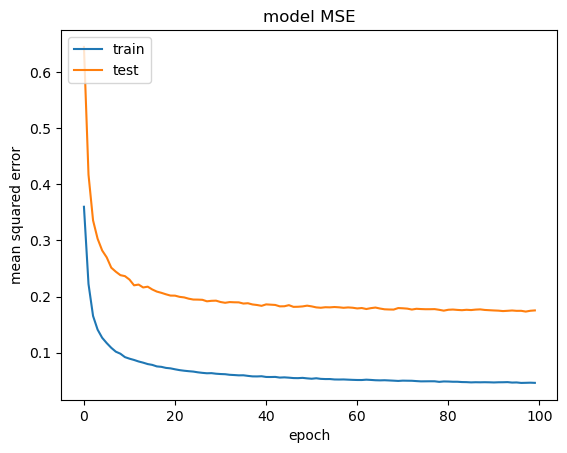

In [13]:
score = model.evaluate(x_test, y_test,verbose=1)
print(score)


plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
if not os.path.isdir(run_directory_path + "/figures"):
    os.mkdir(run_directory_path + "/figures")
plt.savefig(run_directory_path + "/figures/training_curve.png", bbox_inches='tight')
plt.show()

# Visualize how well the model predicted PAMDA profiles on for test set

1/1 [==============================] - 0s 22ms/step


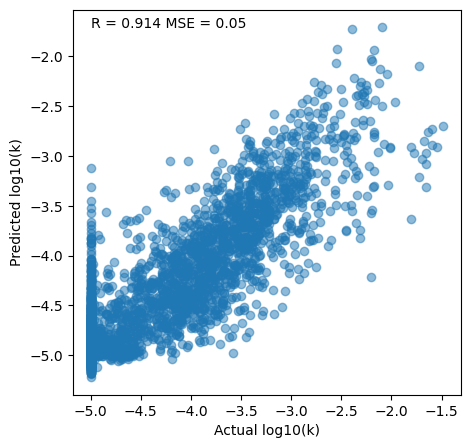

R^2 on test set: 0.832901338996941


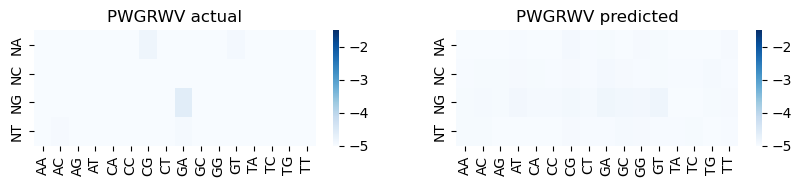

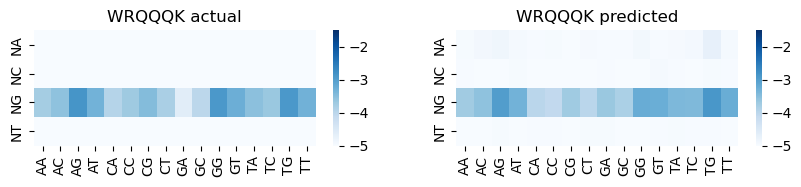

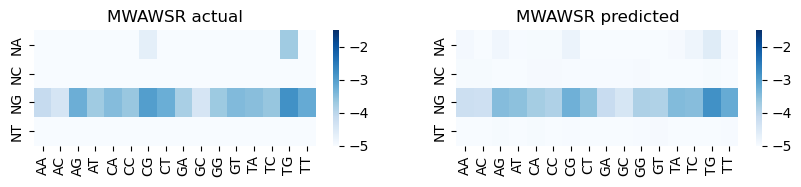

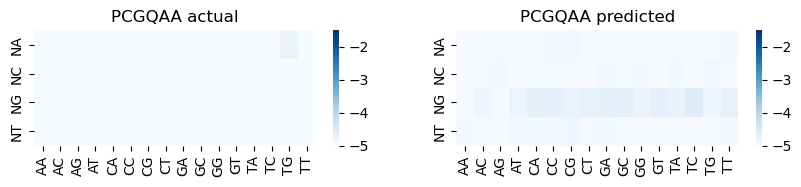

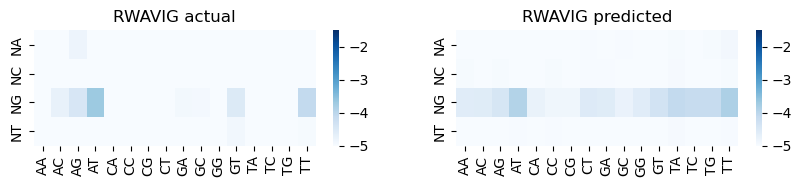

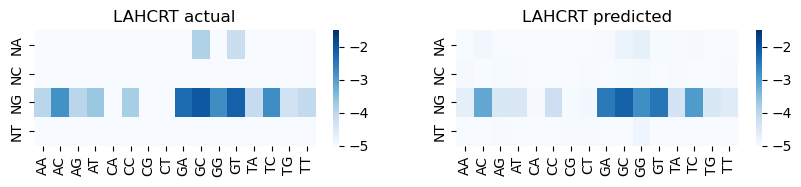

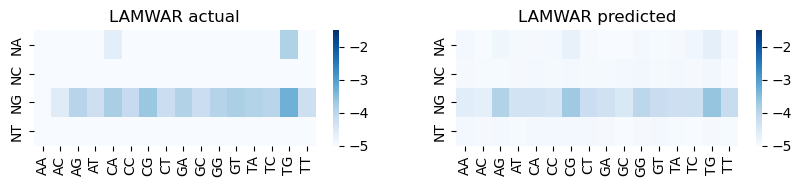

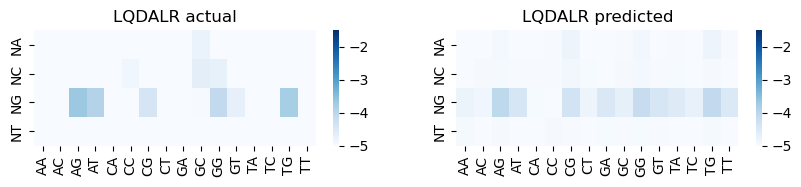

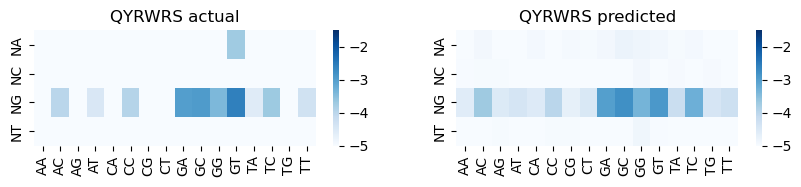

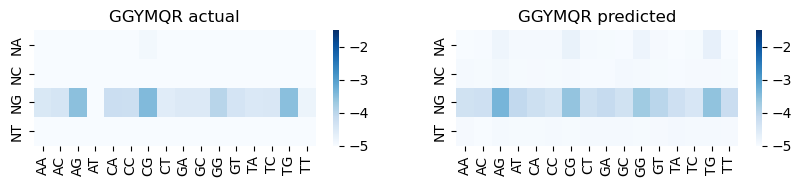

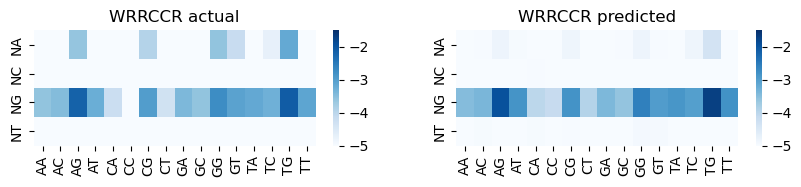

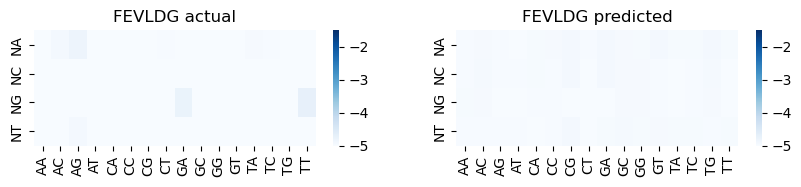

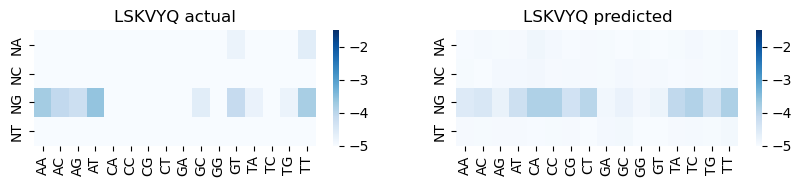

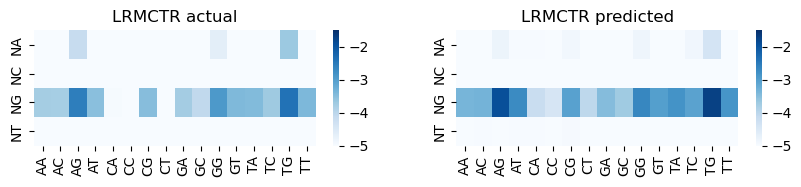

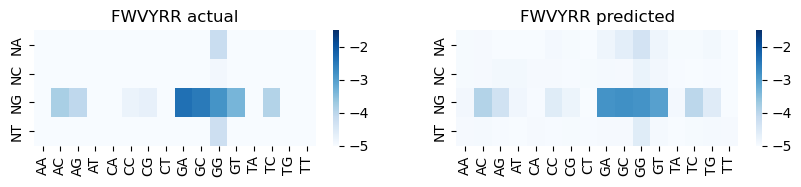

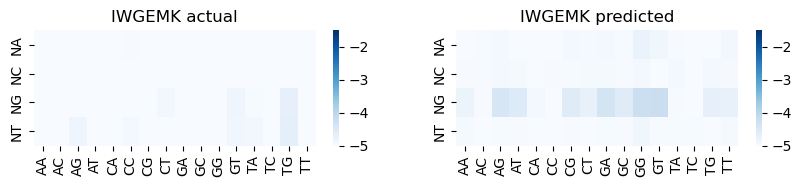

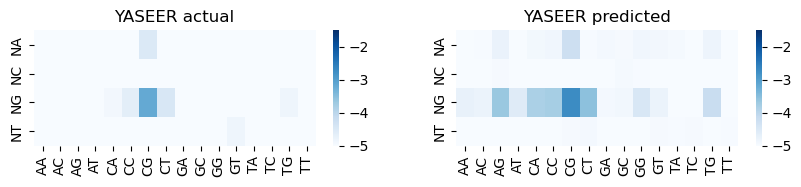

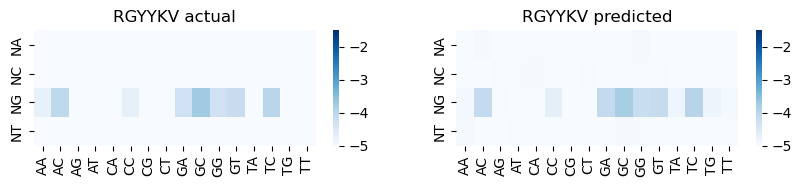

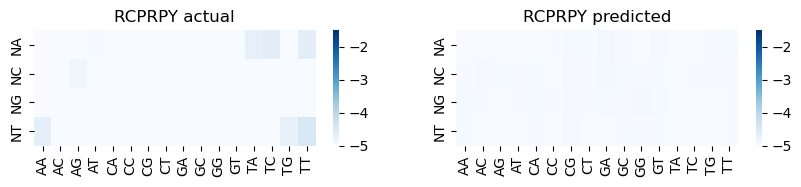

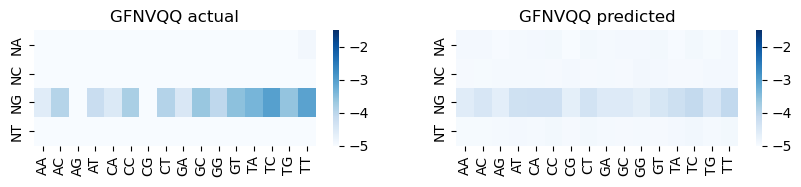

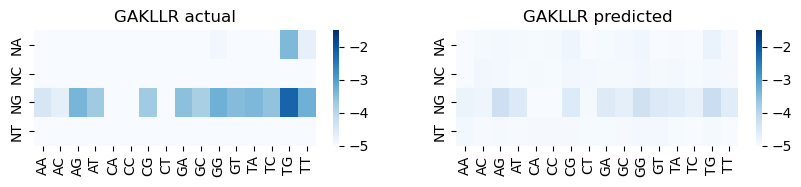

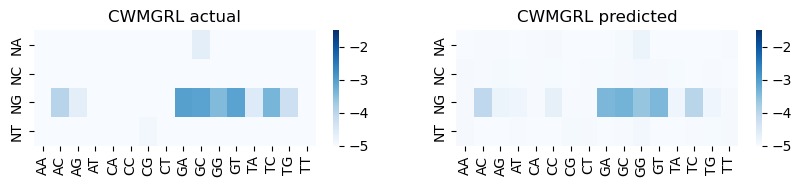

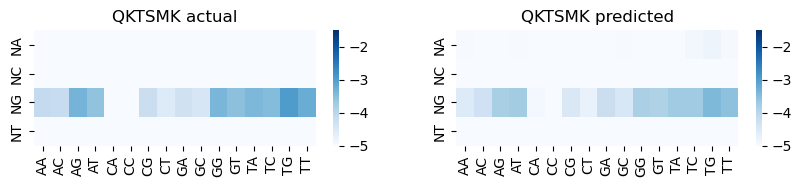

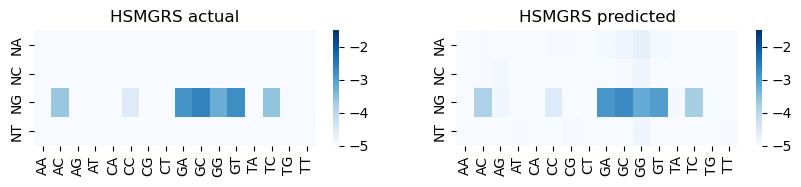

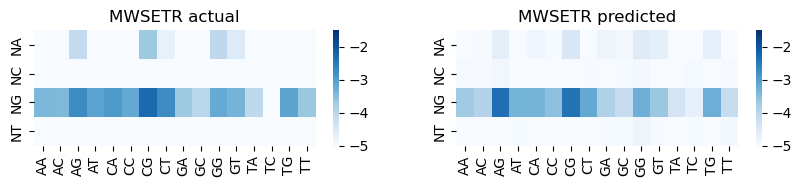

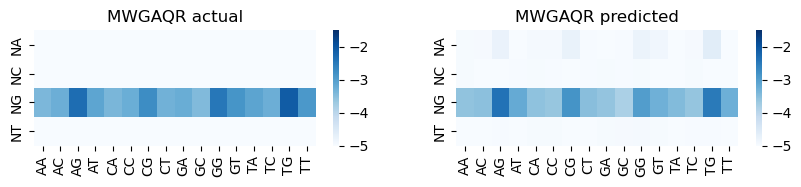

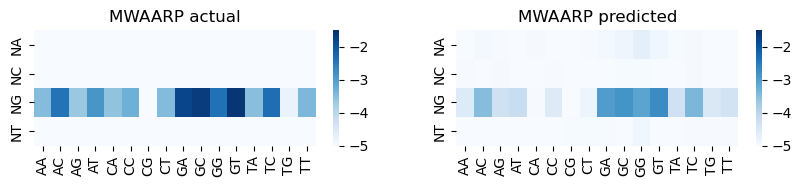

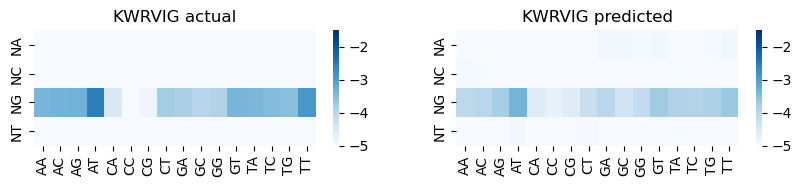

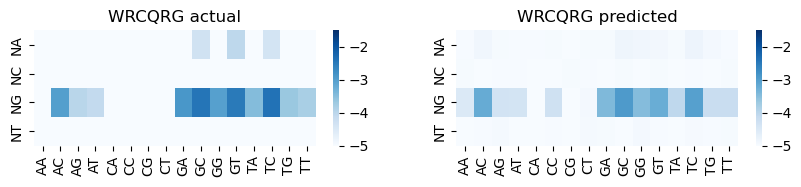

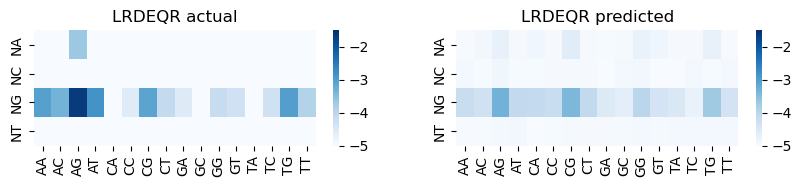

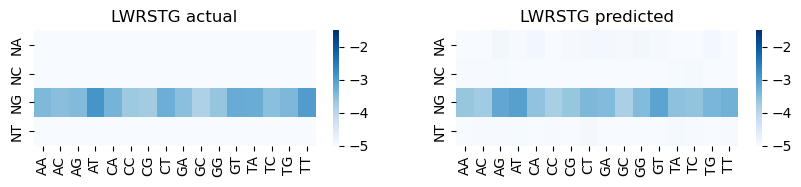

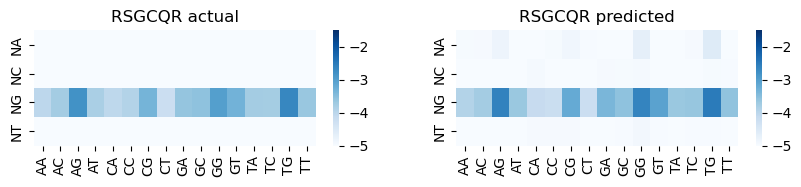

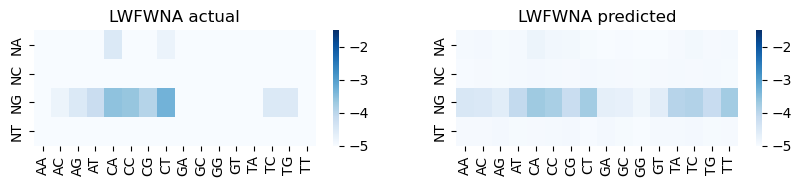

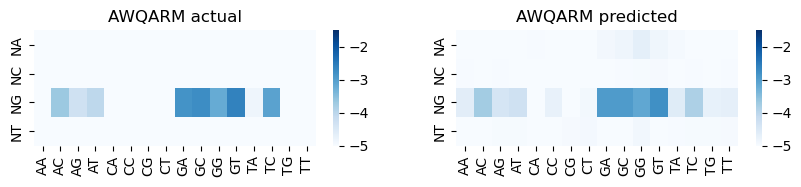

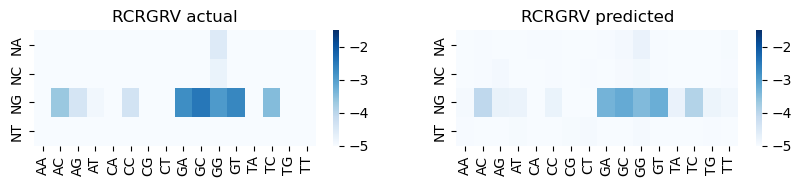

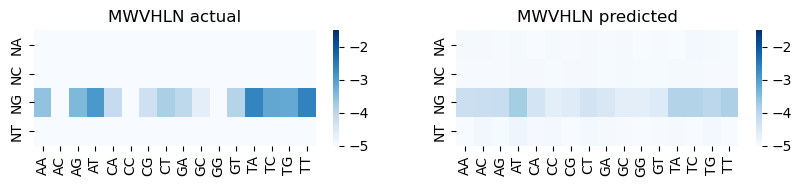

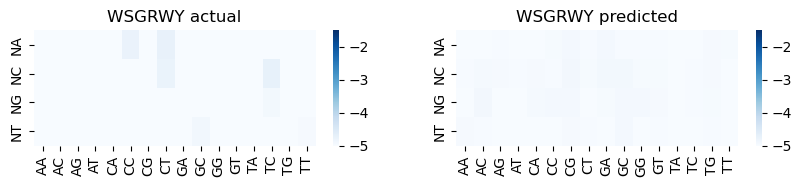

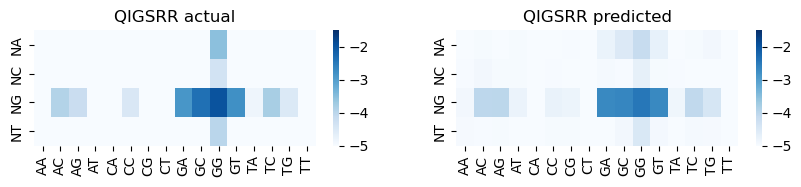

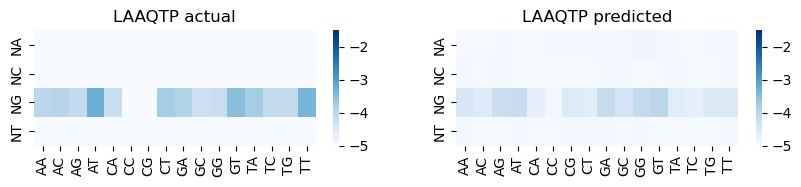

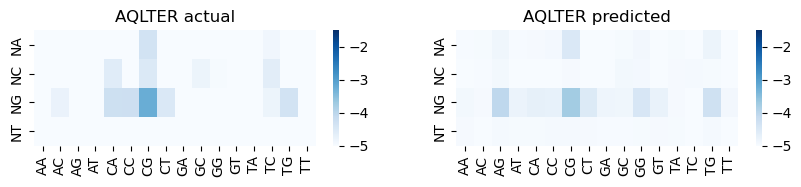

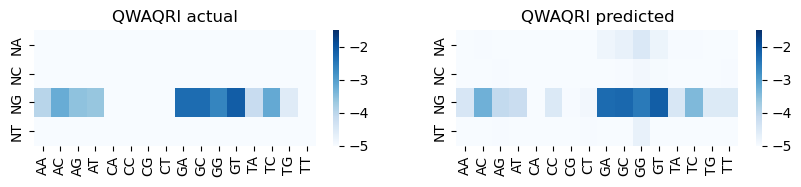

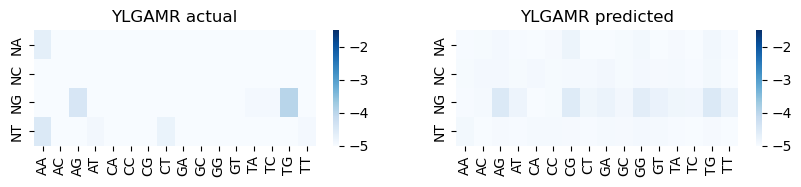

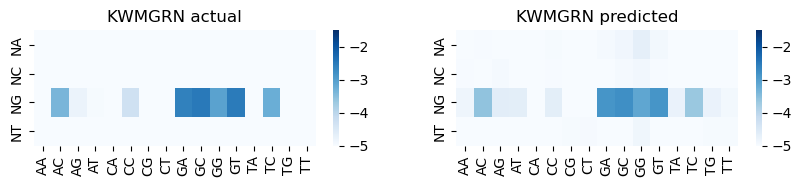

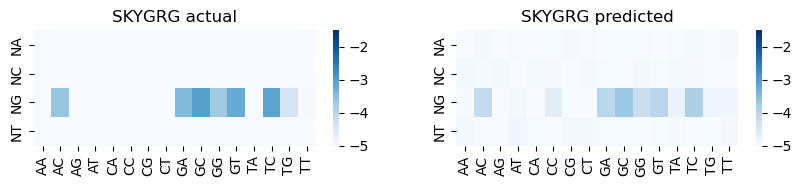

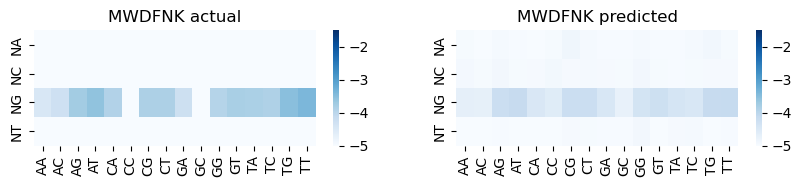

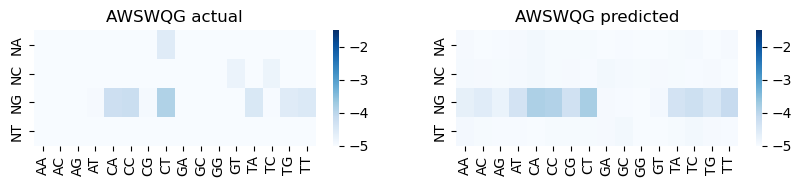

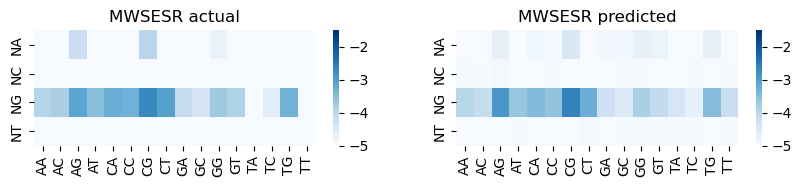

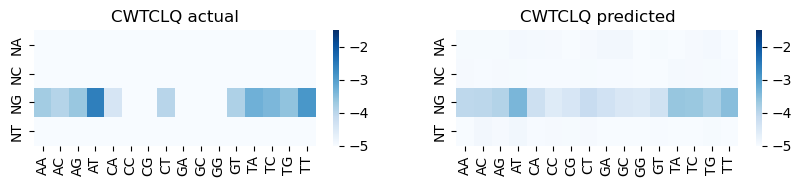

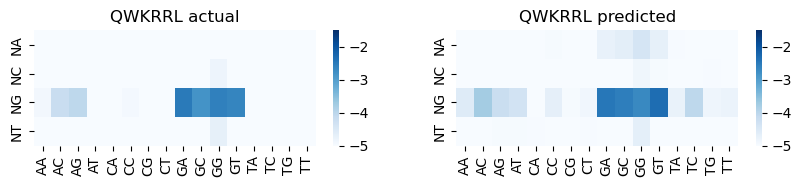

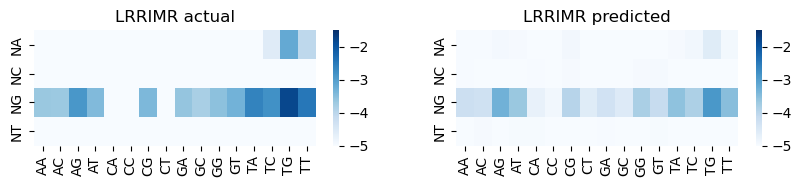

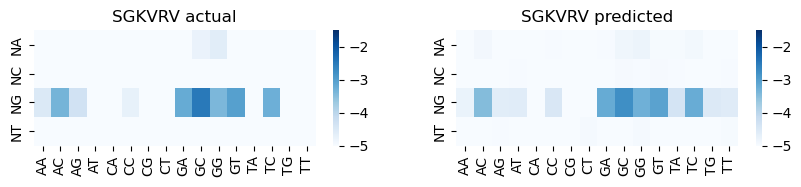

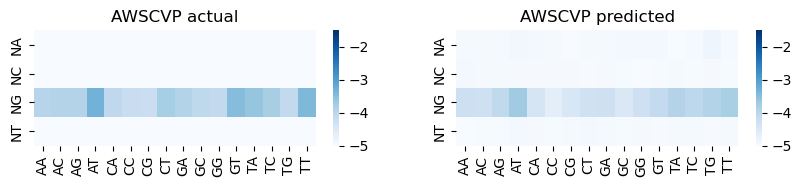

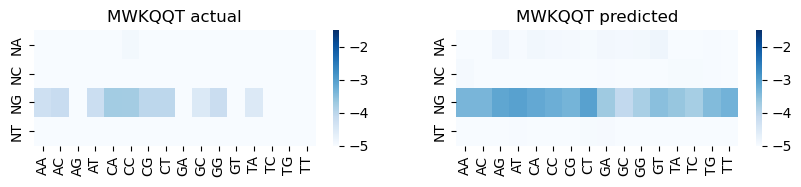

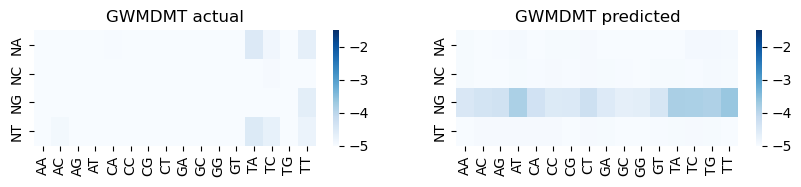

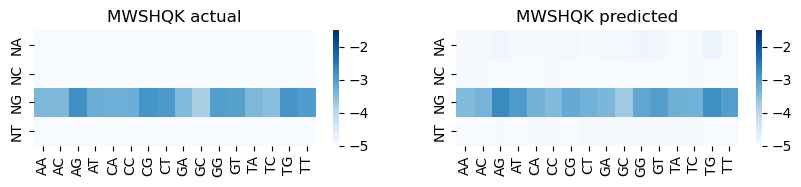

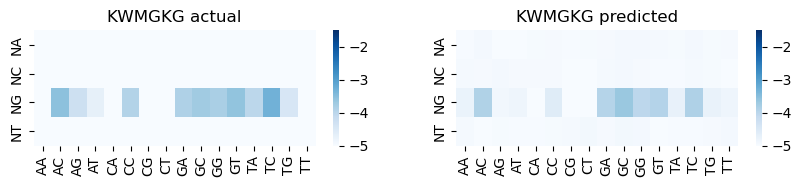

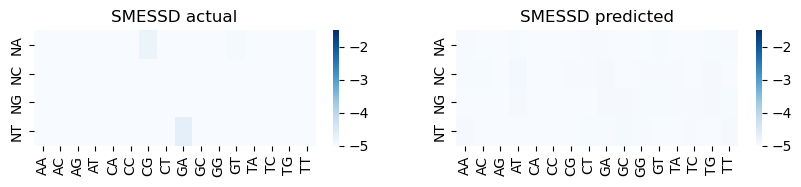

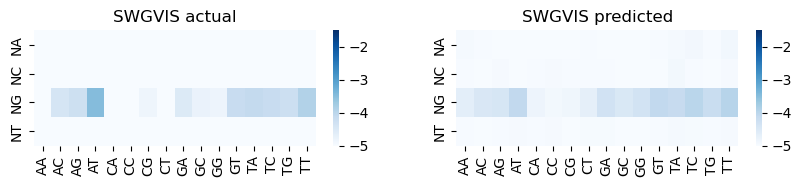

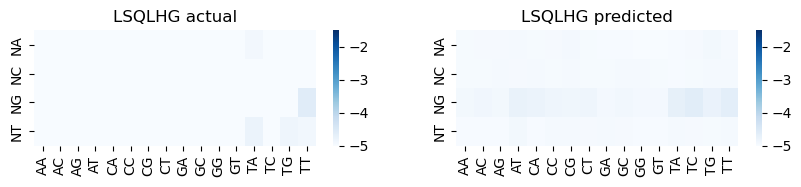

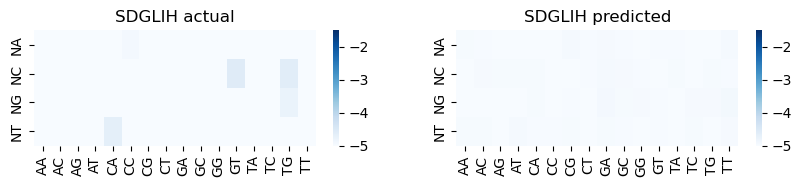

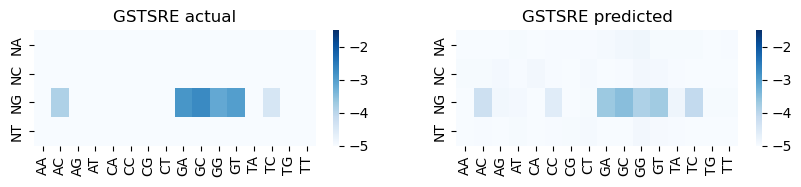

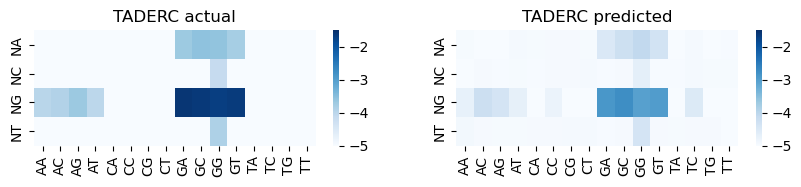

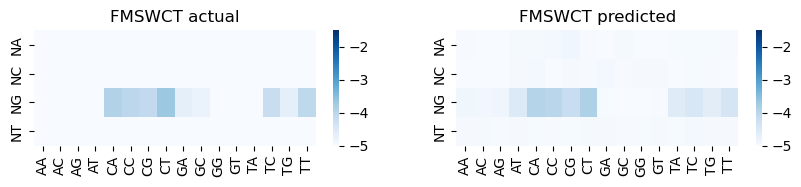

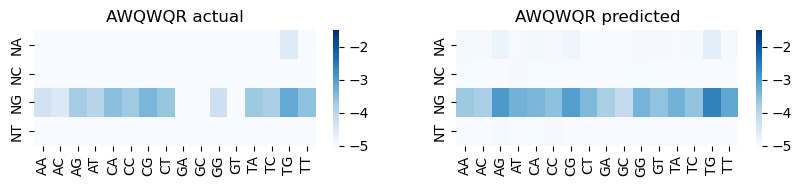

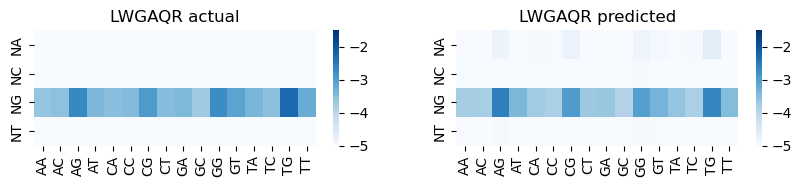

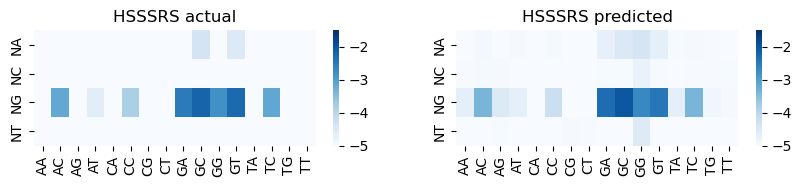

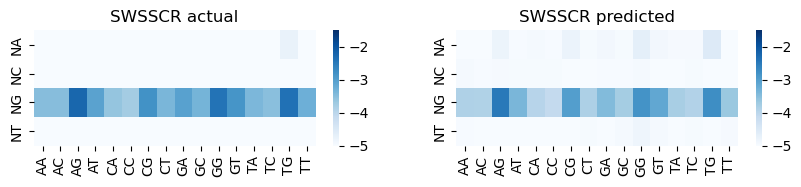

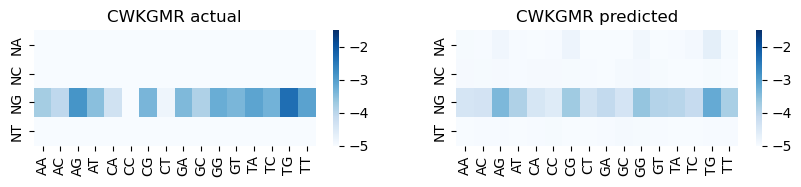

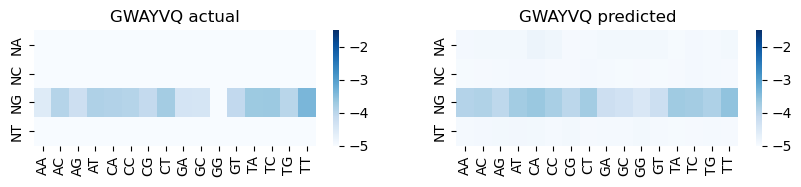

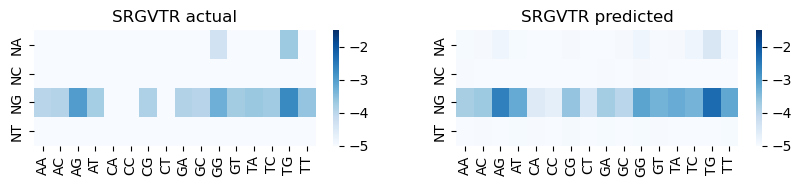

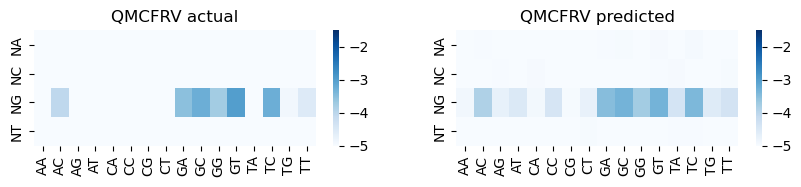

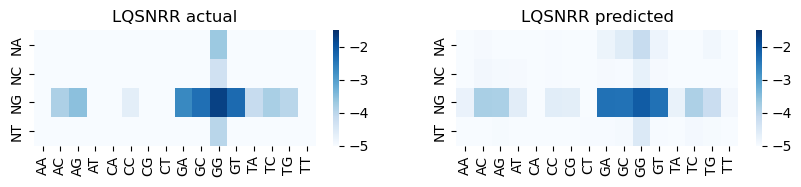

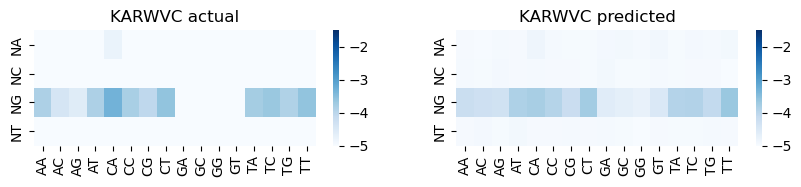

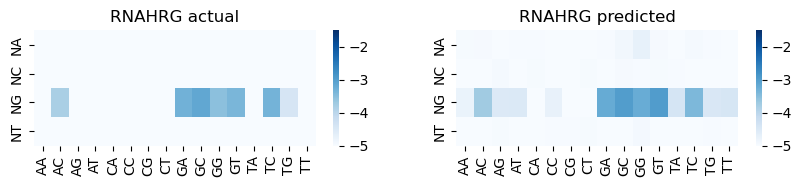

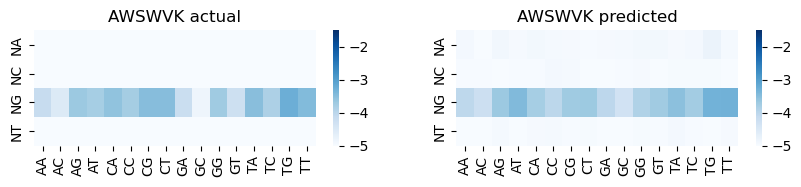

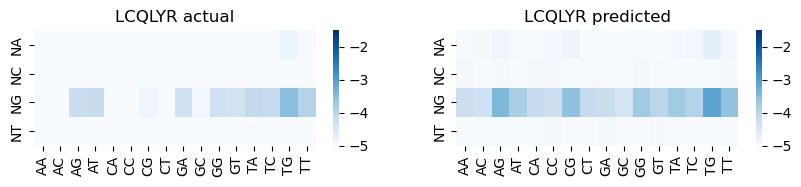

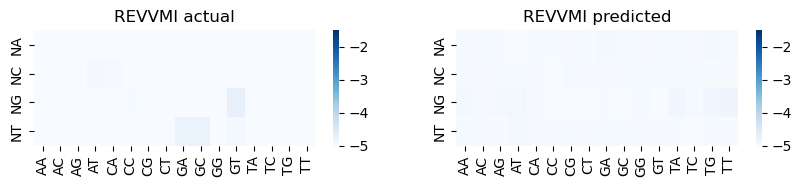

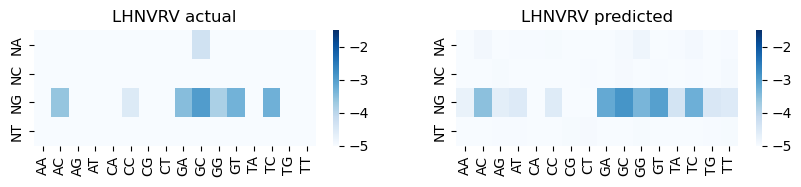

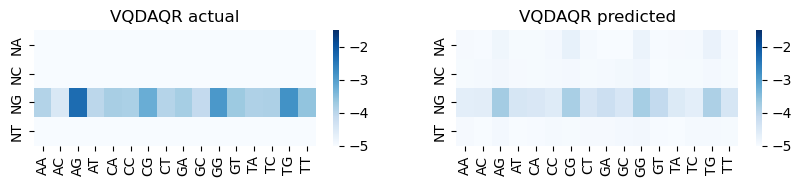

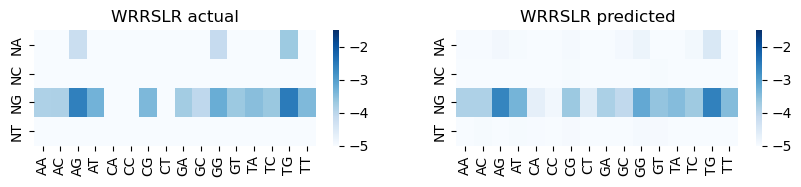

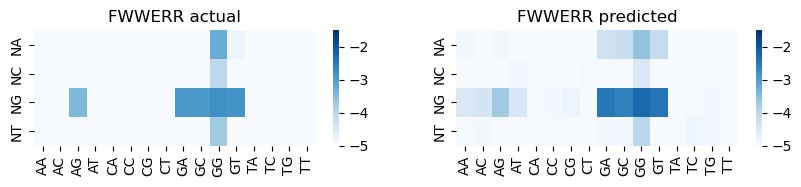

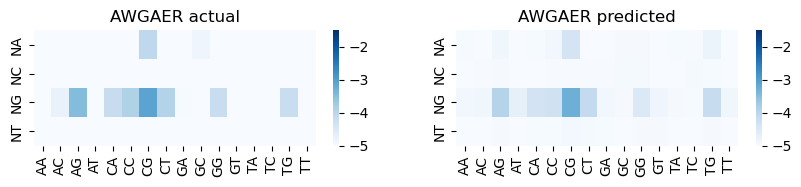

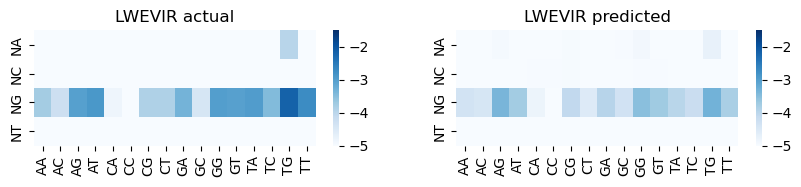

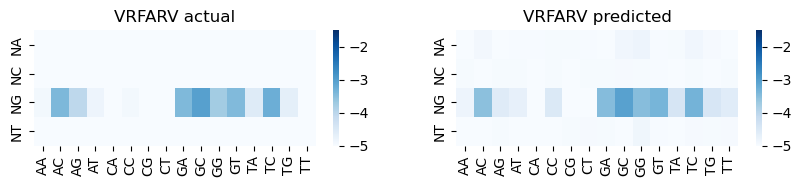

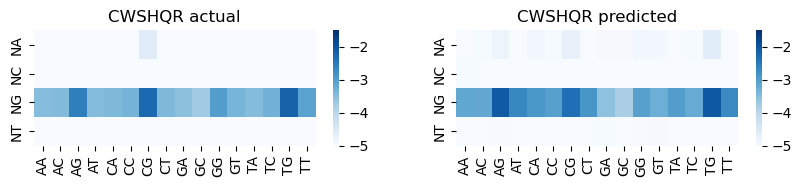

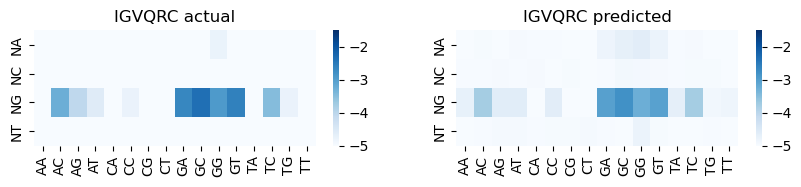

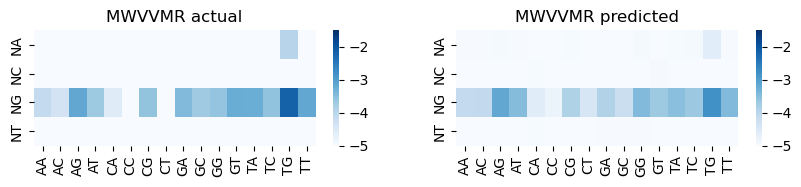

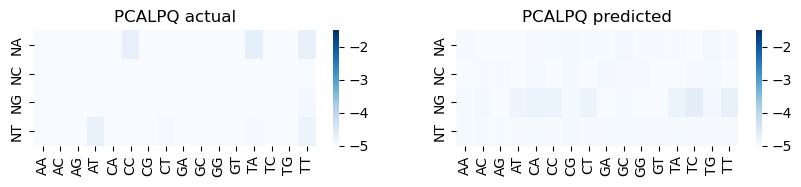

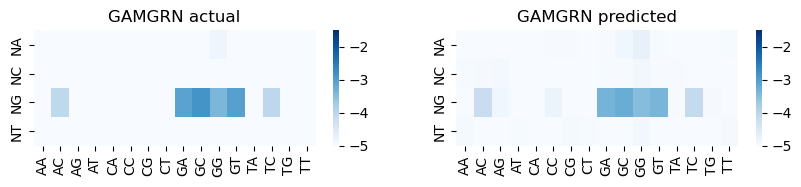

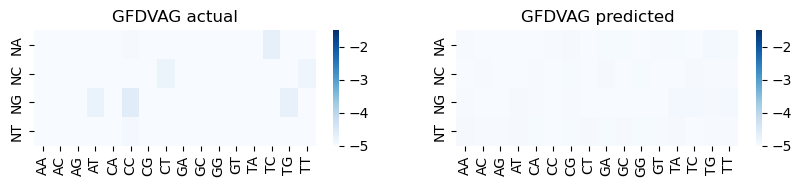

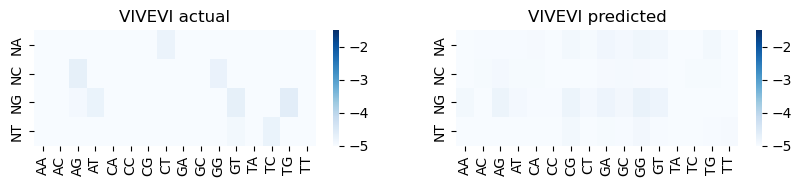

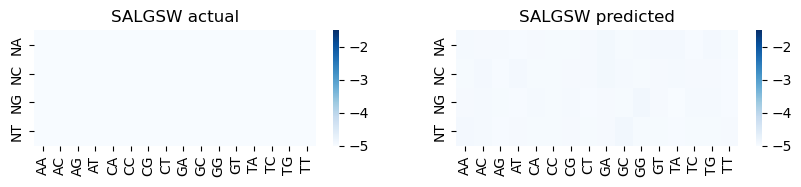

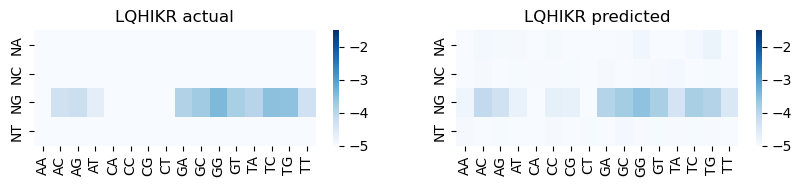

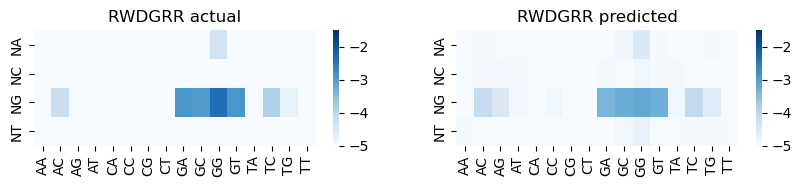

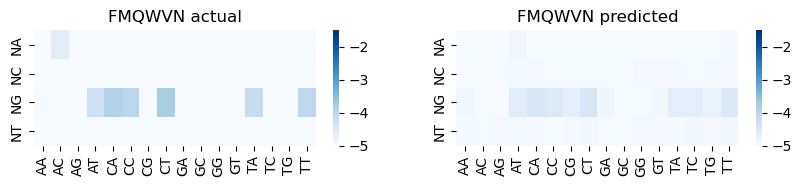

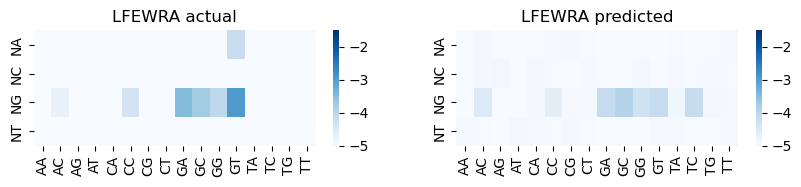

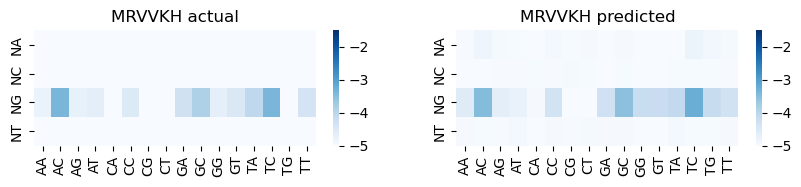

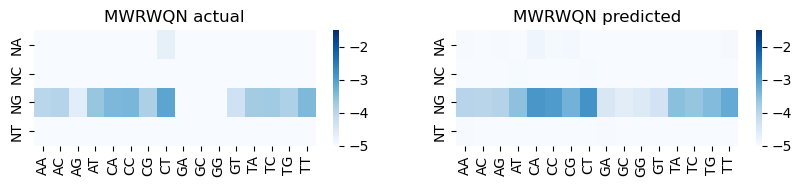

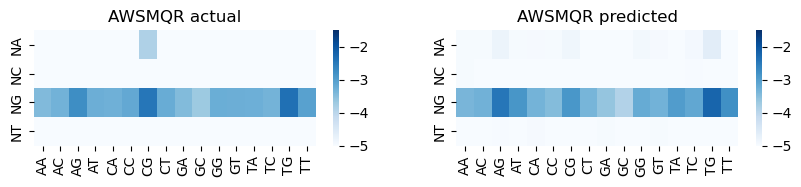

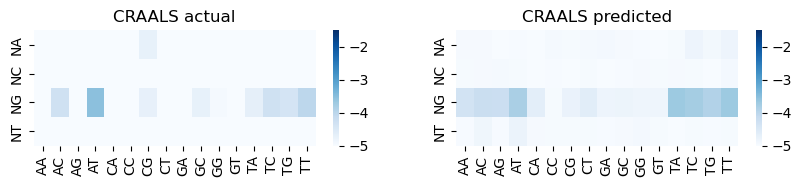

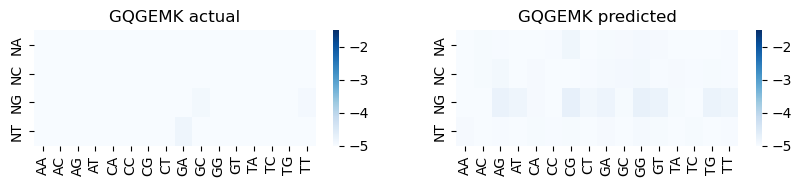

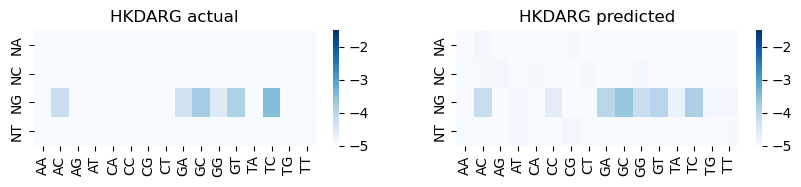

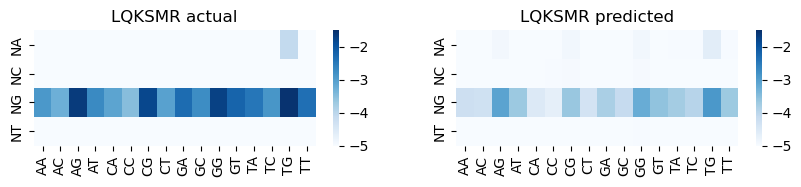

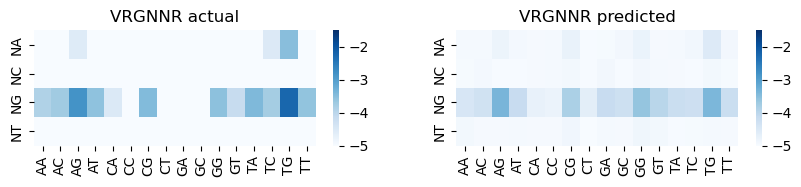

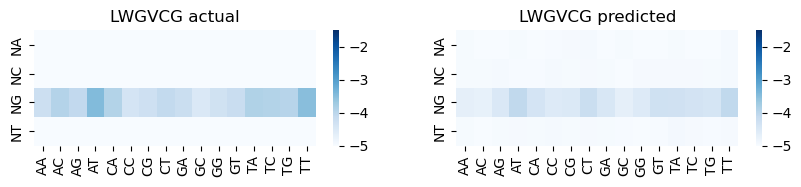

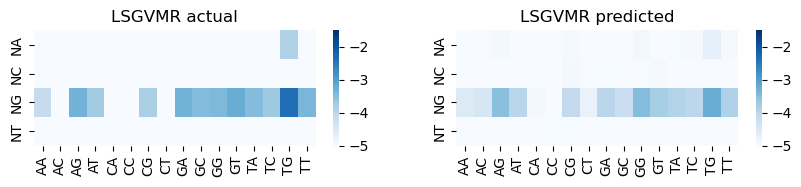

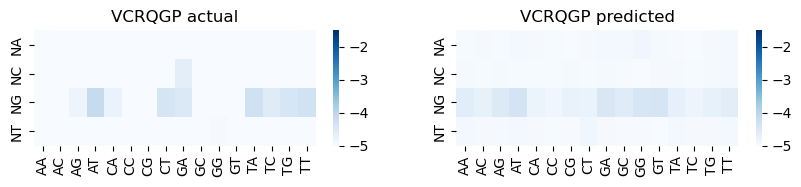

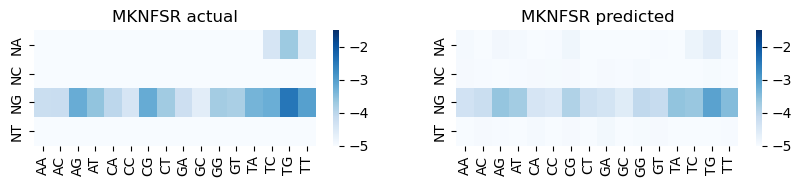

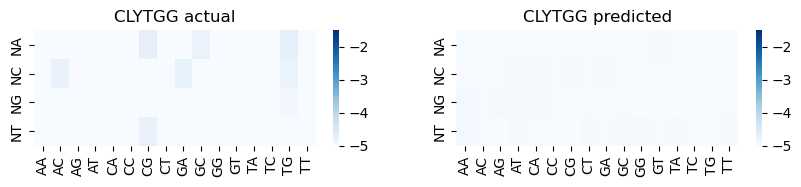

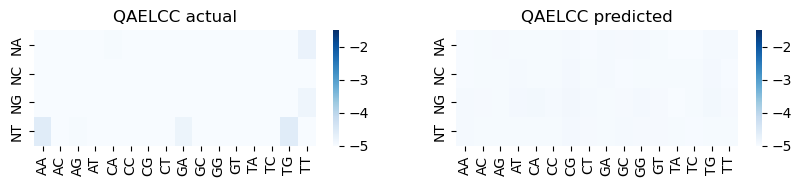

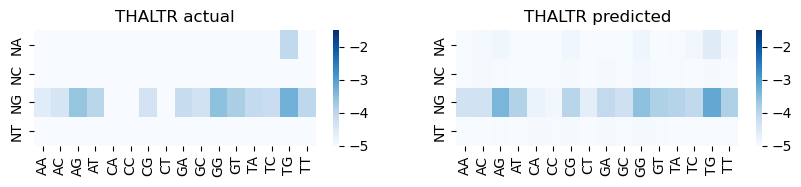

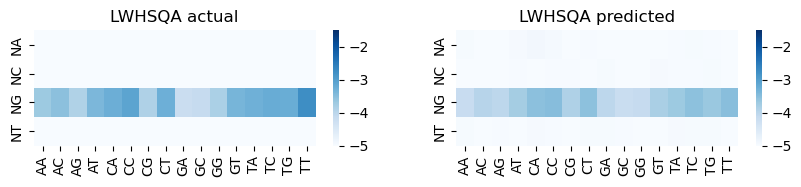

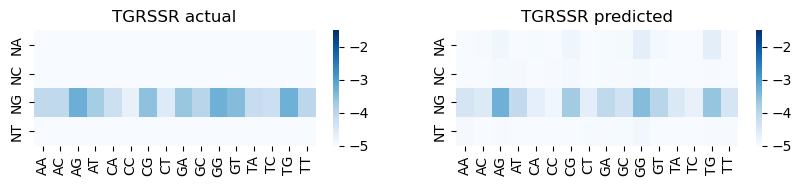

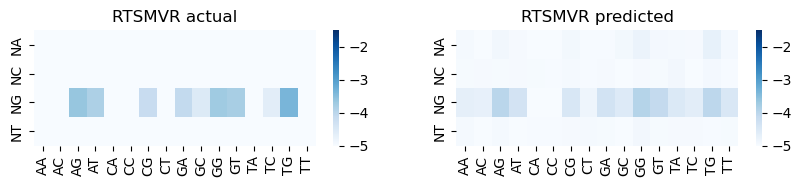

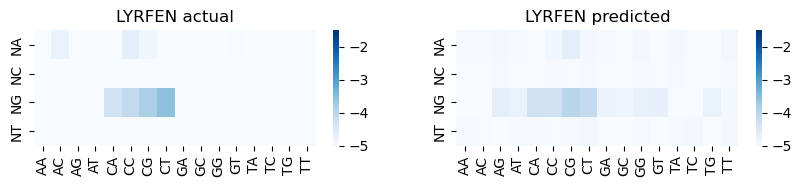

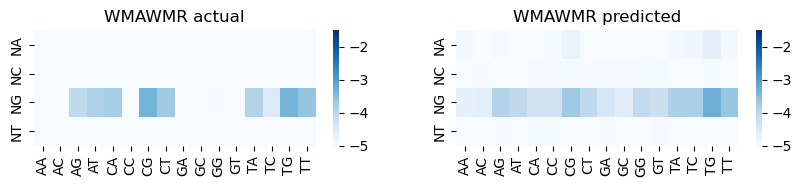

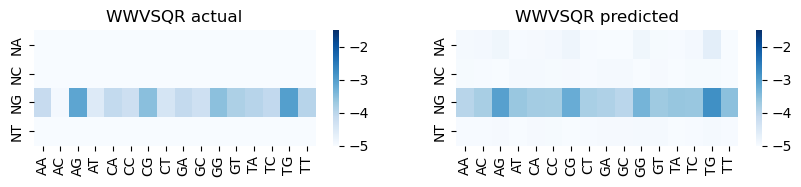

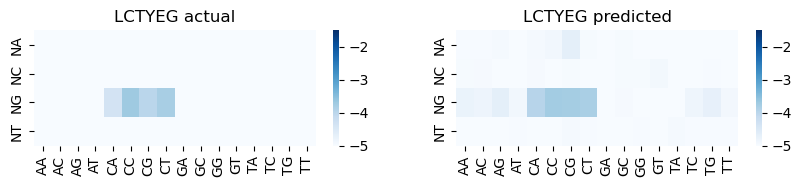

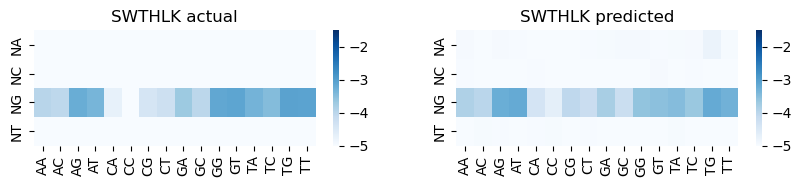

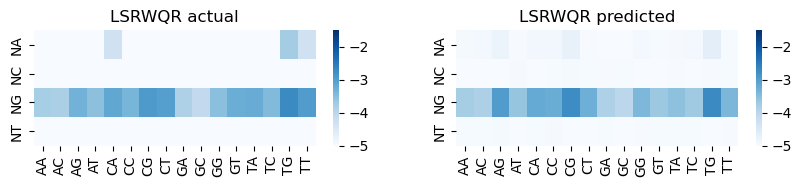

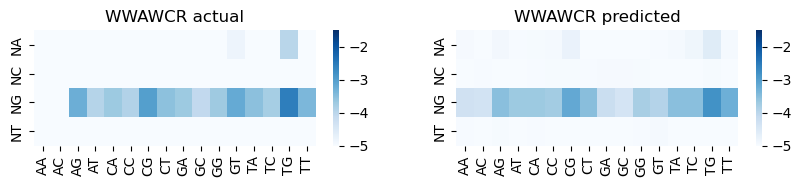

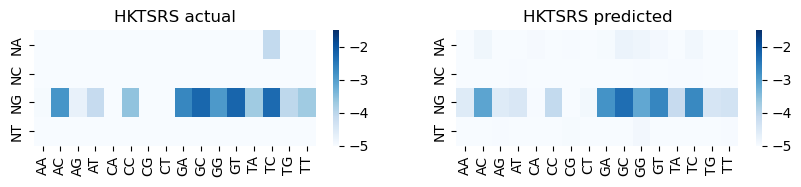

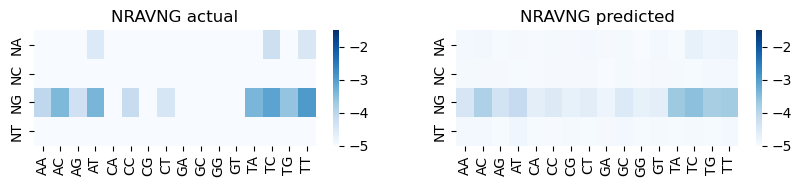

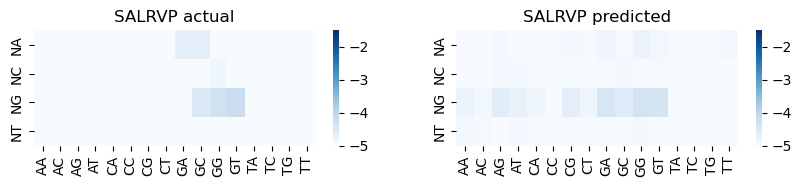

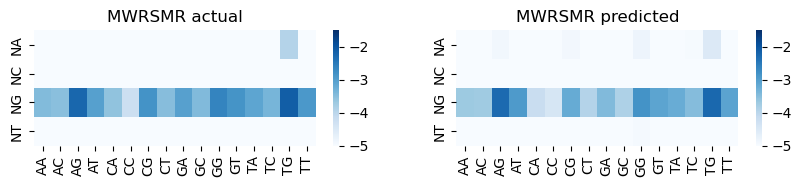

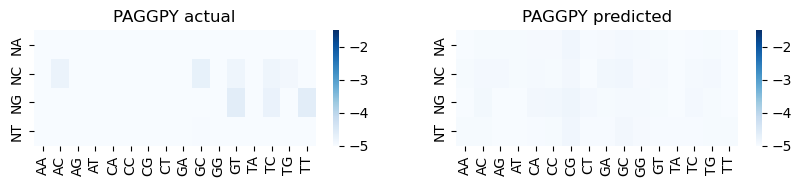

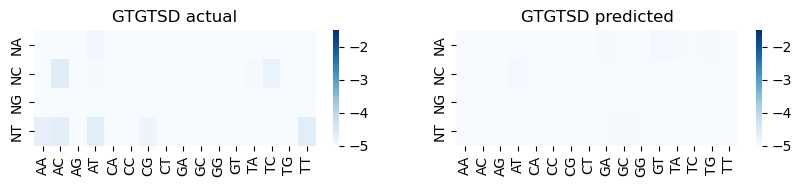

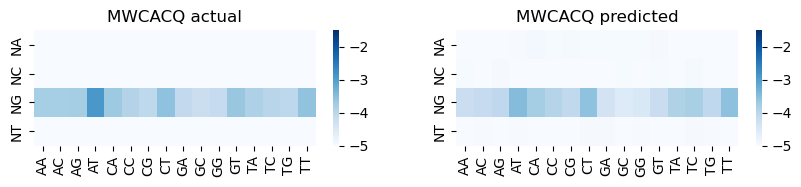

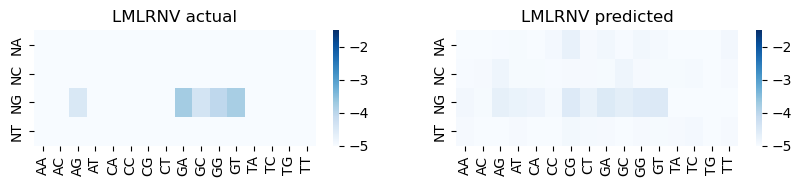

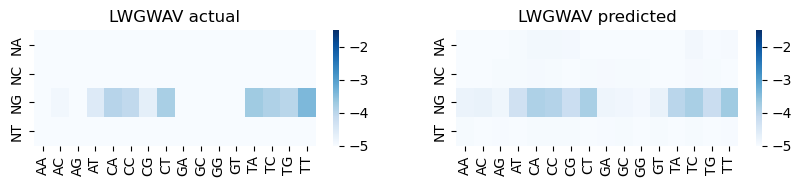

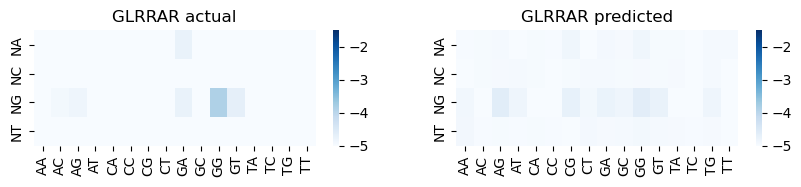

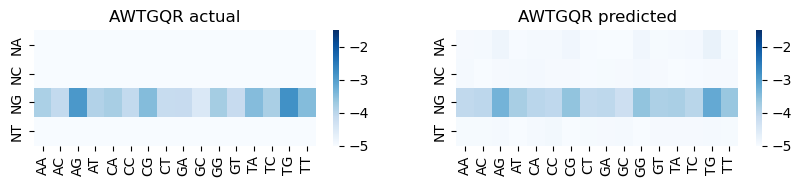

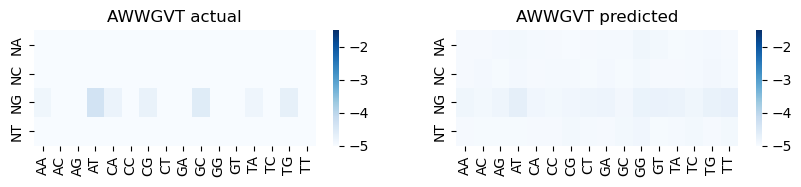

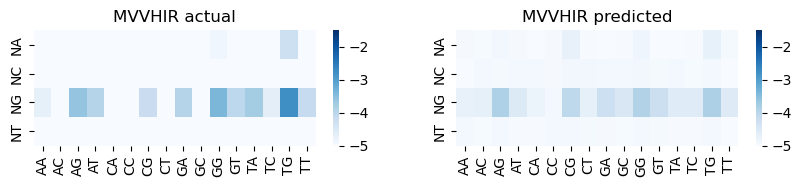

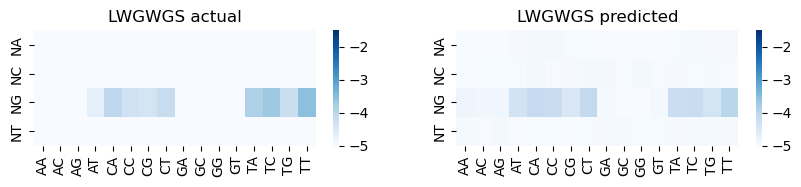

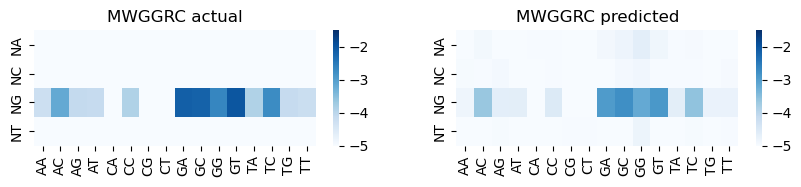

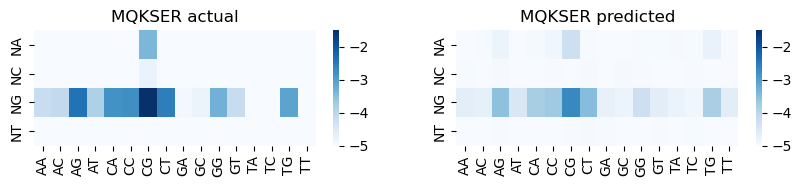

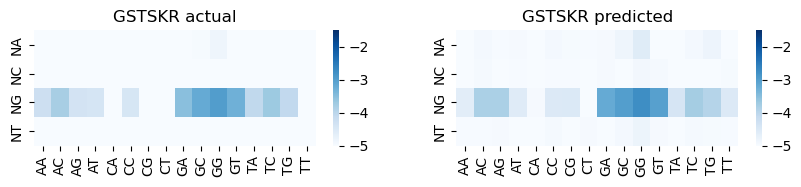

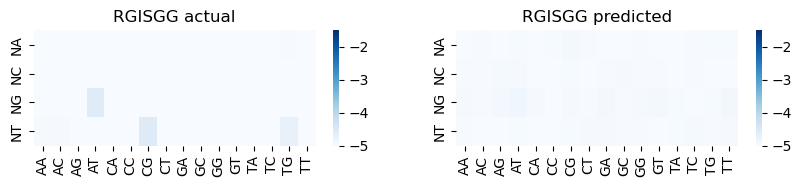

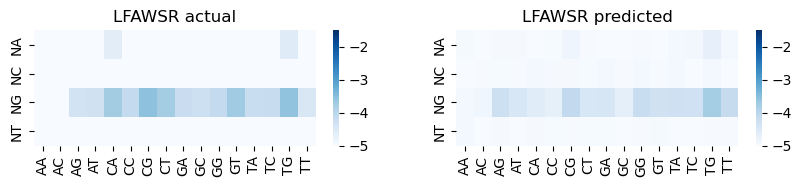

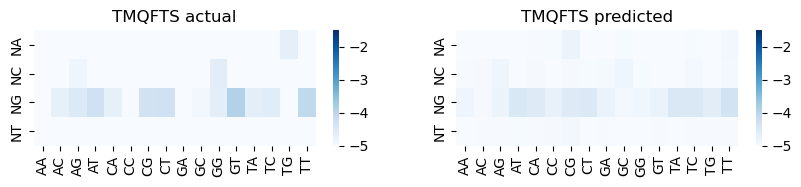

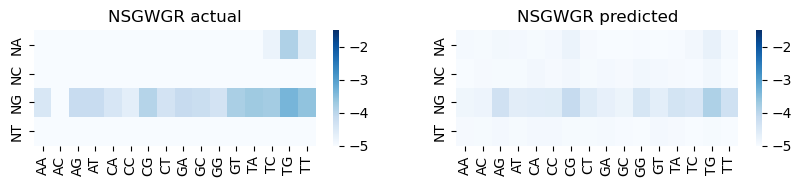

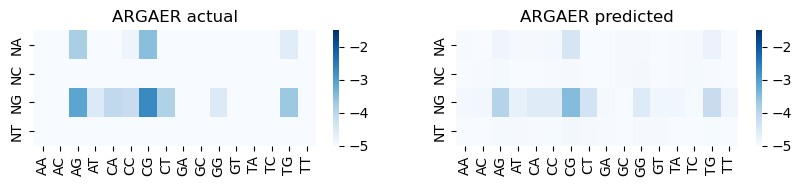

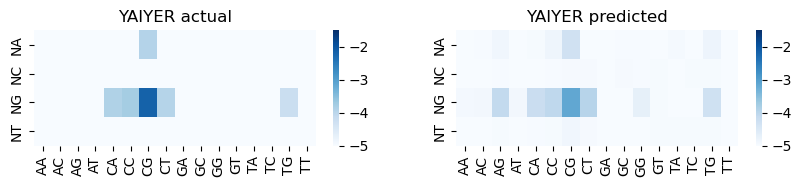

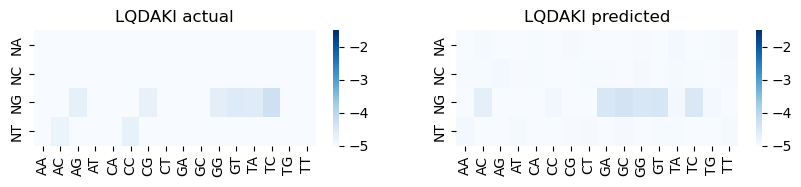

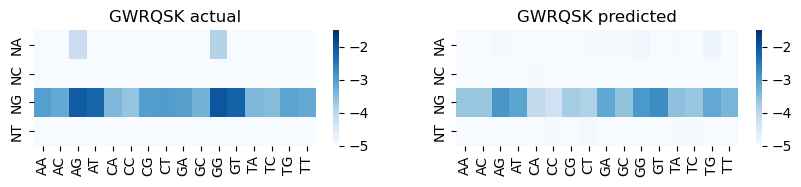

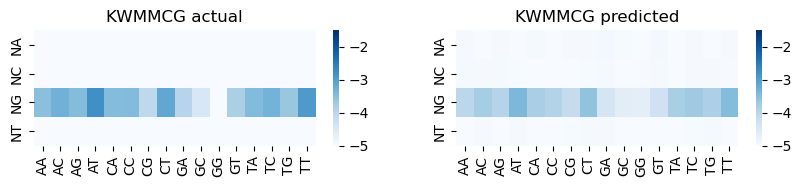

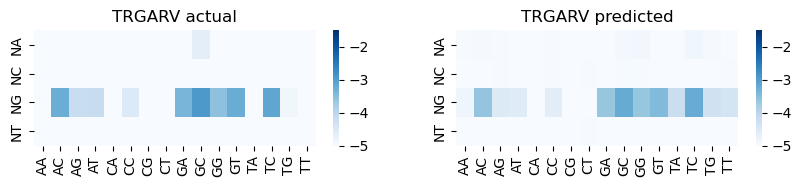

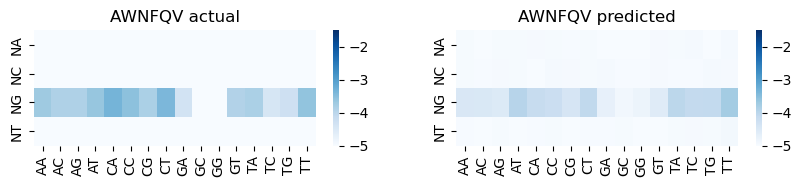

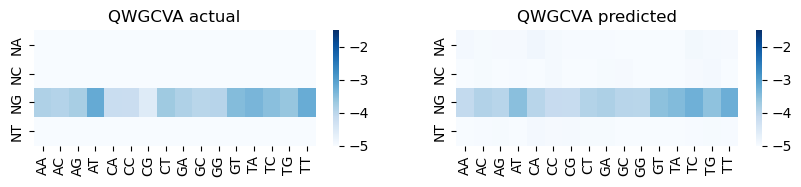

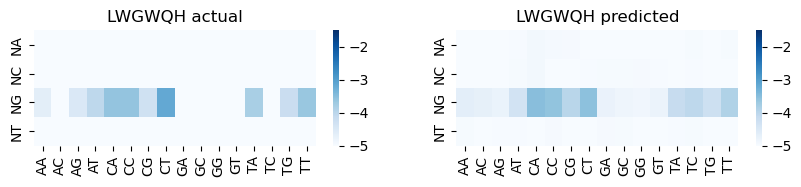

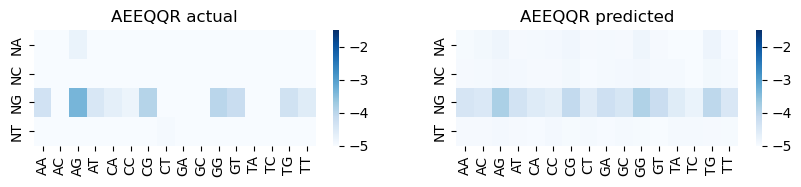

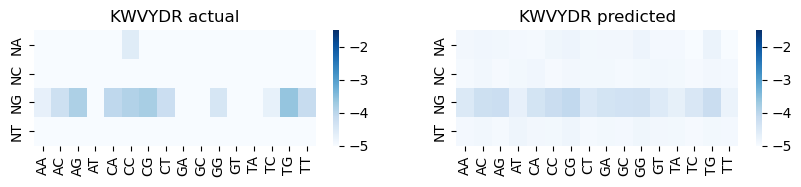

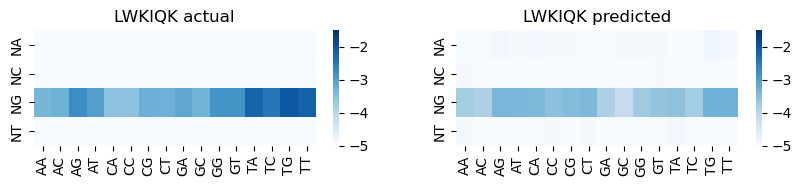

In [14]:
y_pred = model.predict(x_test, batch_size=len(x_test))
names = test_PAMDA_df.name

# unnormalize the data
y_pred_unnorm = unnormalize(y_pred, DATA_MEAN, DATA_STD)
y_test_unnorm = unnormalize(y_test, DATA_MEAN, DATA_STD)
np.savetxt(run_directory_path + "/test_set_predictions.csv",y_pred_unnorm, delimiter =",")
np.savetxt(run_directory_path + "/test_set_rates_actual.csv",y_test_unnorm, delimiter =",")
    
plot_correlation(y_pred_unnorm, y_test_unnorm, run_directory_path + "/figures/test_set_correlation.png")
# get R^2 score
r2_test_set = r2_score(y_test_unnorm.flatten(), y_pred_unnorm.flatten())
print("R^2 on test set:", r2_test_set)  
    
for i in range(len(y_pred)):
    predicted = y_pred_unnorm[i]
    actual = y_test_unnorm[i]
    predicted = pd.DataFrame([predicted], columns = pams)
    actual = pd.DataFrame([actual], columns = pams)
    output_path = run_directory_path + "/figures/test_set_comparison_heatmaps"
    if not os.path.isdir(output_path):
        os.mkdir(output_path)
    stripped_name = names[i].strip(r'[\\/*?:"<>|]')
    ax = plot_paired_heatmaps(actual, predicted, names[i], HEATMAP_MAX, HEATMAP_MIN)
    plt.savefig(output_path + "/" + stripped_name, bbox_inches='tight')
    plt.show()
    

## Save the model

In [ ]:
model.save(run_directory_path + "/saved_model", overwrite=OVERWRITE_SAVED_MODEL)